# Keypoint Partition v2

#### By Albert Gong

Write keypoints using JSON format instead of YAML. YAML tags require OpenCV.

In [13]:
import json
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from pprint import pprint
import math
from collections import OrderedDict
import cv2

%matplotlib inline

In [14]:
OPENPOSE_ROOT = '/home/albert/openpose/'

img_file = OPENPOSE_ROOT + 'examples/media/albert/woman.jpg'
pose_file = OPENPOSE_ROOT + 'examples/media/albert/pose/woman_keypoints.json'
render_file = OPENPOSE_ROOT + 'examples/media/albert/render/woman_rendered.png'
heatmap_file = OPENPOSE_ROOT + 'output_heatmaps_folder/woman_heatmaps.png'

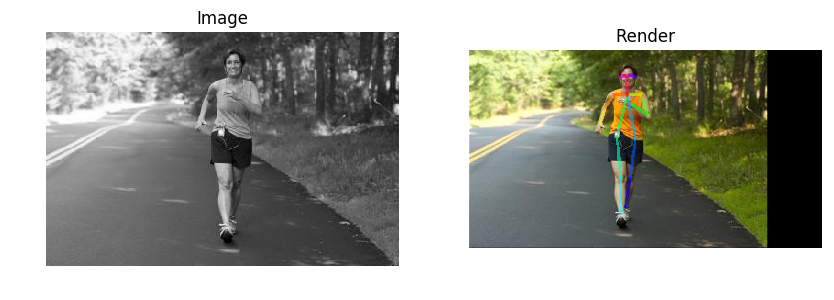

In [15]:
img = cv2.cvtColor(cv2.imread(img_file),cv2.COLOR_BGR2GRAY)
render = misc.imread(render_file)
heatmap_img = misc.imread(heatmap_file)

plt.figure(figsize=(10,6), dpi=100)

plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Image')

plt.subplot(122)
plt.imshow(render)
plt.axis('off')
plt.title('Render')

plt.show()

### Keypoint Extraction

In [16]:
with open(pose_file) as data_file:    
    data = json.load(data_file)

pprint(data)

{u'people': [{u'face_keypoints': [],
              u'hand_left_keypoints': [],
              u'hand_right_keypoints': [],
              u'pose_keypoints': [203.138,
                                  36.2122,
                                  0.927631,
                                  203.834,
                                  58.4489,
                                  0.88429,
                                  186.439,
                                  58.462,
                                  0.852873,
                                  175.328,
                                  75.1257,
                                  0.837863,
                                  169.715,
                                  95.9763,
                                  0.864393,
                                  221.205,
                                  58.4497,
                                  0.836837,
                                  230.963,
                                  85.5502,
              

In [17]:
for p in range(len(data['people'])):
    for k_type in data['people'][p].keys():
        pose_dict = {'x' : [], 'y' : [], 'c' : []}
        
        for i in range(len(data['people'][p][k_type])):
            if i % 3 == 0:
                pose_dict['x'].append(data['people'][p][k_type][i])
            elif i % 3 == 1:
                pose_dict['y'].append(data['people'][p][k_type][i])
            else:
                pose_dict['c'].append(data['people'][p][k_type][i])
        
        data['people'][p][k_type] = pose_dict

### Display Keypoints

In [18]:
BODY_PARTS = [
    "Nose",
    "Neck",
    "RShoulder",
    "RElbow",
    "RWrist",
    "LShoulder",
    "LElbow",
    "LWrist",
    "RHip",
    "RKnee",# Add 10 to remove blown-out artifacts
    "RAnkle",
    "LHip",
    "LKnee",
    "LAnkle",
    "REye",
    "LEye",
    "REar",
    "LEar",
    "Bkg",
]

In [19]:
def dist(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [20]:
img_arr = np.zeros(img.shape, dtype=np.uint8)

In [21]:
print(img_arr.shape)

(256, 385)


In [23]:
r_keypoint = 5

for p in range(len(data['people'])):
    for i in range(len(data['people'][p]['pose_keypoints']['x'])):
        x_key = data['people'][p]['pose_keypoints']['x'][i]
        y_key = data['people'][p]['pose_keypoints']['y'][i]
        c_key = data['people'][p]['pose_keypoints']['c'][i]

        for x in range(img_arr.shape[1]):
            for y in range(img_arr.shape[0]):
                if dist(x, y, x_key, y_key) < r_keypoint:
                    intensity = 255 * c_key
                    img_arr[y][x] = np.array(intensity, dtype=np.uint8)

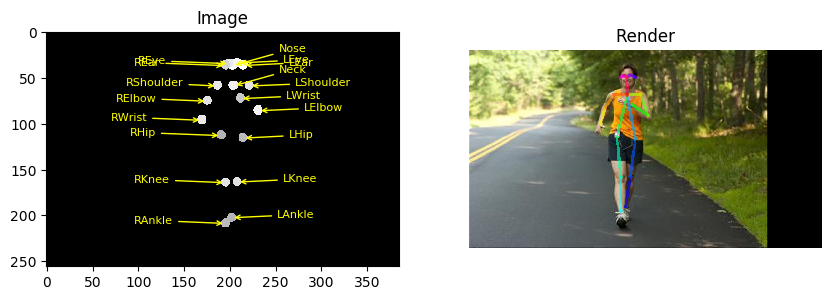

In [26]:
plt.figure(figsize=(10,6), dpi=100)

plt.subplot(121)
plt.imshow(img_arr, cmap=plt.cm.gray)
# plt.axis('off')
plt.title('Image')

for p in range(len(data['people'])):
    for i in range(len(data['people'][p]['pose_keypoints']['x'])):
        x_key = data['people'][p]['pose_keypoints']['x'][i]
        y_key = data['people'][p]['pose_keypoints']['y'][i]
        if BODY_PARTS[i][0] == 'R':
            plt.annotate(BODY_PARTS[i], xy=(x_key,y_key), xytext=(x_key - 100, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})
        elif BODY_PARTS[i][0] =='L':
            plt.annotate(BODY_PARTS[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})
        else:
            plt.annotate(BODY_PARTS[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key - 15), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})

plt.subplot(122)
plt.imshow(render)
plt.axis('off')
plt.title('Render')

plt.show()

In [27]:
data_partition = {u'people': [{u'face_keypoints': {'x': [], 'y': []},
                  u'hand_left_keypoints': {'x': [], 'y': []},
                  u'hand_right_keypoints': {'x': [], 'y': []},
                  u'pose_keypoints': {'x': [], 'y': []}}],
                  u'version': 1.0}

In [28]:
# Use OrderedDict class to maintain order of dictionary 
# so that the annotated numbers correspond accurately to body part
PARTITION_BODY_PARTS = OrderedDict([
    ('RArm', [BODY_PARTS.index('RShoulder'), BODY_PARTS.index('RElbow')]),
    ('RForearm', [BODY_PARTS.index('RElbow'), BODY_PARTS.index('RWrist')]),
    ('LArm', [BODY_PARTS.index('LShoulder'), BODY_PARTS.index('LElbow')]),
    ('LForearm', [BODY_PARTS.index('LElbow'), BODY_PARTS.index('LWrist')]),
    ('Chest', [BODY_PARTS.index('RShoulder'), BODY_PARTS.index('LShoulder')]),
    ('RTorso', [BODY_PARTS.index('Neck'), BODY_PARTS.index('RHip')]),
    ('LTorso', [BODY_PARTS.index('Neck'), BODY_PARTS.index('LHip')]),
    ('RHip', [BODY_PARTS.index('RHip')]),
    ('CHip', [BODY_PARTS.index('RHip'), BODY_PARTS.index('LHip')]),
    ('LHip', [BODY_PARTS.index('LHip')]),
    ('RThigh', [BODY_PARTS.index('RHip'), BODY_PARTS.index('RKnee')]),
    ('LThigh', [BODY_PARTS.index('LHip'), BODY_PARTS.index('LKnee')]),
    ('RShin', [BODY_PARTS.index('RKnee'), BODY_PARTS.index('RAnkle')]),
    ('LShin', [BODY_PARTS.index('LKnee'), BODY_PARTS.index('LAnkle')]),
    ('RFoot', [BODY_PARTS.index('RAnkle')]),
    ('LFoot', [BODY_PARTS.index('LAnkle')]),
    ('Back', [BODY_PARTS.index('RShoulder'), BODY_PARTS.index('LShoulder')]),
])

In [29]:
for p in range(len(data_partition['people'])):
    for body_pt in PARTITION_BODY_PARTS.keys():
#         Each new key point is an average of the key points listed in the corresponding array in PARTITION_BODY_PARTS
        x_key = int(np.mean(np.array([data['people'][p]['pose_keypoints']['x'][i] for i in PARTITION_BODY_PARTS[body_pt]])))
        y_key = int(np.mean(np.array([data['people'][p]['pose_keypoints']['y'][i] for i in PARTITION_BODY_PARTS[body_pt]])))
        data_partition['people'][p]['pose_keypoints']['x'].append(x_key)
        data_partition['people'][p]['pose_keypoints']['y'].append(y_key)

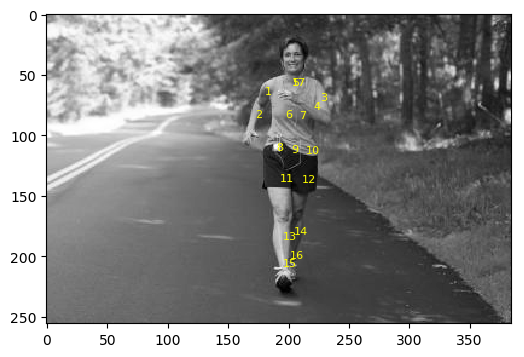

In [31]:
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('on')
for p in range(len(data_partition['people'])):
    for i in range(len(data_partition['people'][p]['pose_keypoints']['x'])):
        x_key = data_partition['people'][p]['pose_keypoints']['x'][i]
        y_key = data_partition['people'][p]['pose_keypoints']['y'][i]
        
        plt.annotate(i + 1, xy=(x_key,y_key), fontsize=8, color='yellow')

plt.show()

### Extracting Individual Heatmaps

In [32]:
def normalize(im):
    return (im * 255.0 / im.max()).astype(np.uint8)

In [33]:
heatmaps = []
htmp_height = heatmap_img.shape[0]
# 57 heatmaps: 18 bodypaf_x[0] + paf_y[0] parts + bkgd + 2 x 19 PAFs
htmp_width = int(heatmap_img.shape[1] / 57);

for i in range(0, 57):
    htmp = np.array(heatmap_img[:, i * htmp_width : (i + 1) * htmp_width])
    htmp_resize = misc.imresize(htmp, float(img.shape[0]) / htmp_height)
    htmp_resize = htmp_resize[:, 0:img.shape[1]]
    heatmaps.append(htmp_resize)
    # plt.imshow(heatmaps[-1], cmap=plt.cm.gray)
    # plt.show()

bdy_pt_htmps = heatmaps[0:18]
bkgd = heatmaps[18]
# Invert background heatmap (use white background instead of black background)
# to produce heatmap with all body parts
all_bdy_pts = [255] - bkgd

pafs = heatmaps[19:]

paf_x = [heatmaps[i] for i in range(19, len(heatmaps), 2)]
paf_y = [heatmaps[i] for i in range(20, len(heatmaps), 2)]

paf_comb = [normalize(paf_x[i].astype(np.uint16) + paf_y[i].astype(np.uint16).astype(np.uint16)) 
            for i in range(len(paf_x))]

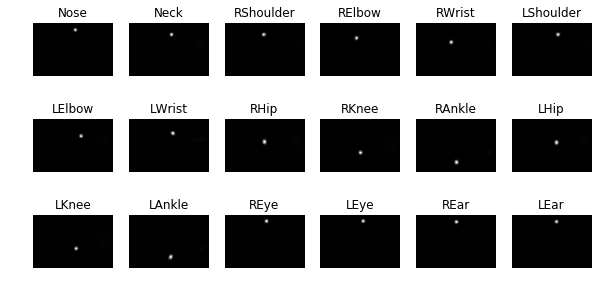

In [34]:
plt.figure(figsize=(10, 5))

for i in range(len(bdy_pt_htmps)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(bdy_pt_htmps[i], cmap=plt.cm.gray)
    plt.title(BODY_PARTS[i])
    plt.axis("off")

plt.show()

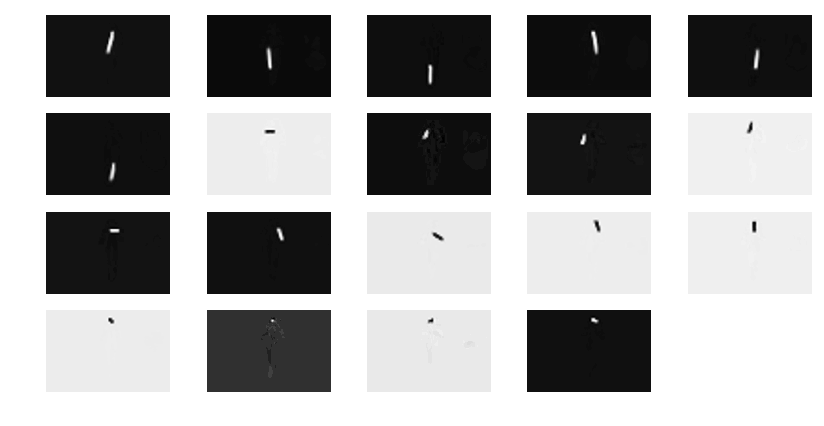

In [35]:
plt.figure(figsize=(10,5), dpi=100)
for i in range(len(paf_comb)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(paf_comb[i], cmap=plt.cm.gray)
    plt.axis("off")
plt.show()

In [122]:
paf_comb_thresh = []
for i in range(len(paf_comb)):
    ret, thresh = cv2.threshold(paf_comb[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     kernel = np.ones((3,3),np.uint8)
#     thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)
    paf_comb_thresh.append(thresh)

In [123]:
for i in range(len(paf_comb_thresh)):
    if paf_comb_thresh[i][0, 0] == 255:
        paf_comb_thresh[i] = 255 - paf_comb_thresh[i]

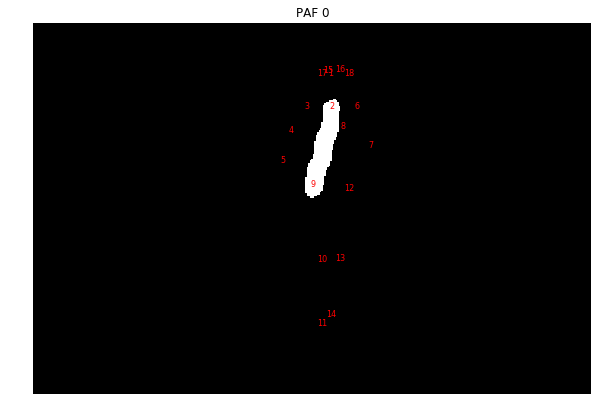

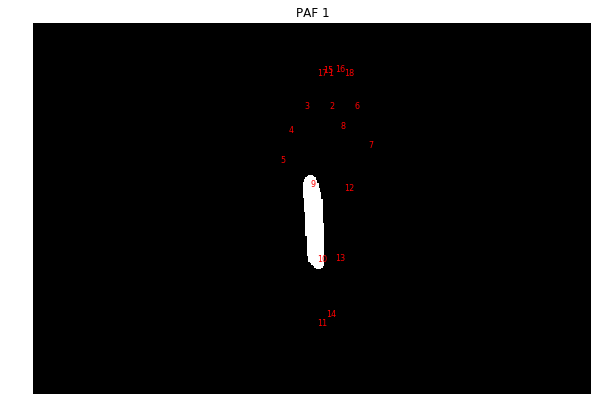

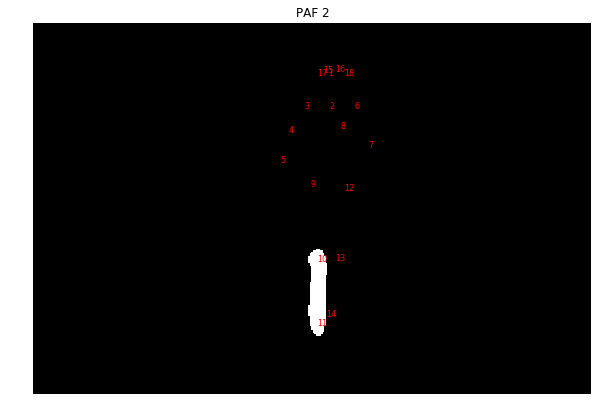

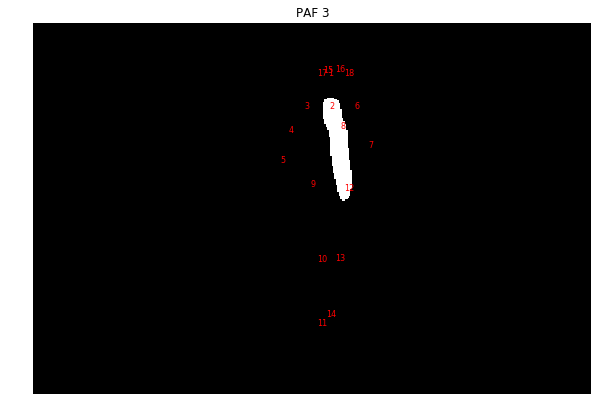

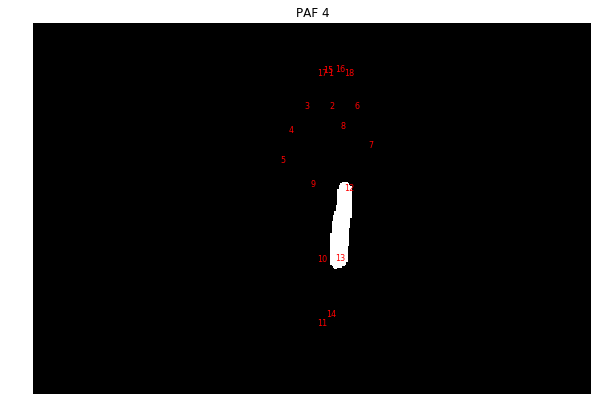

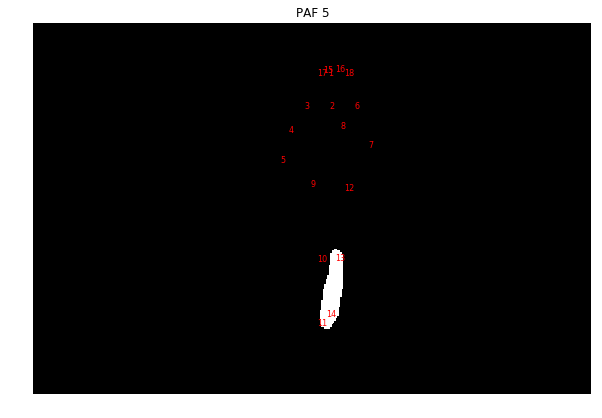

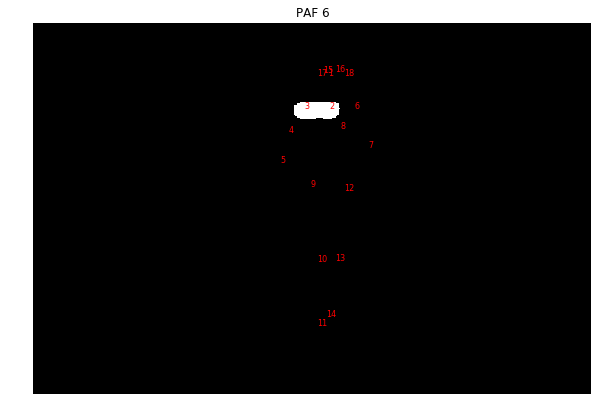

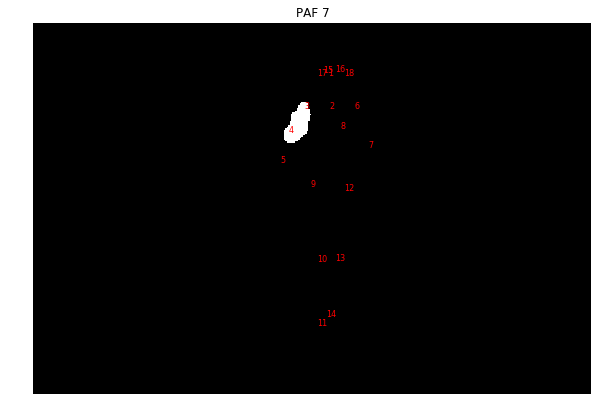

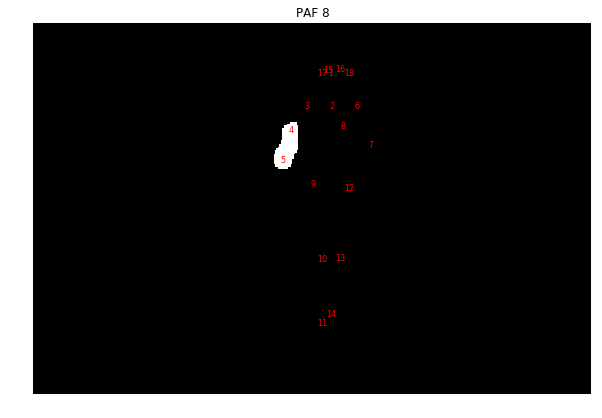

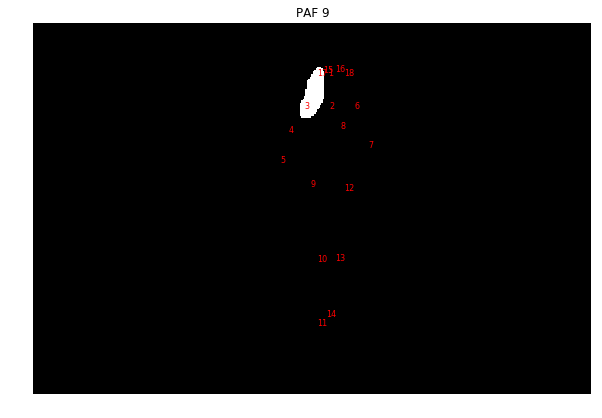

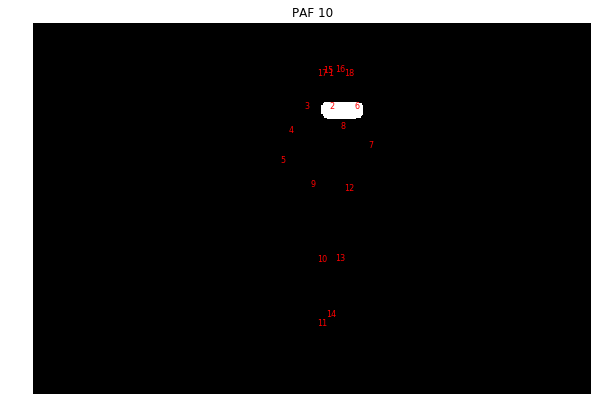

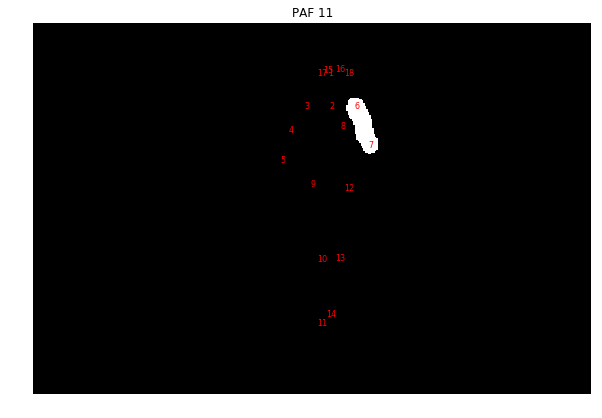

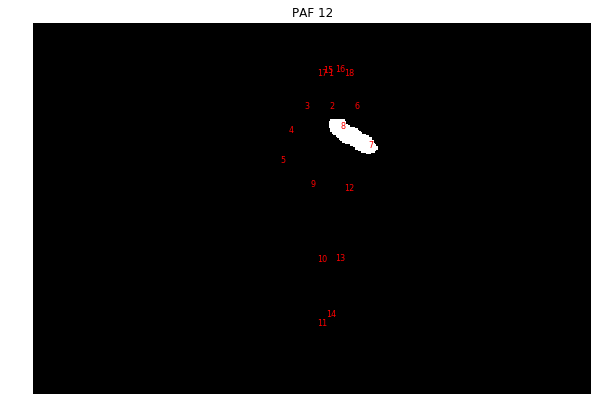

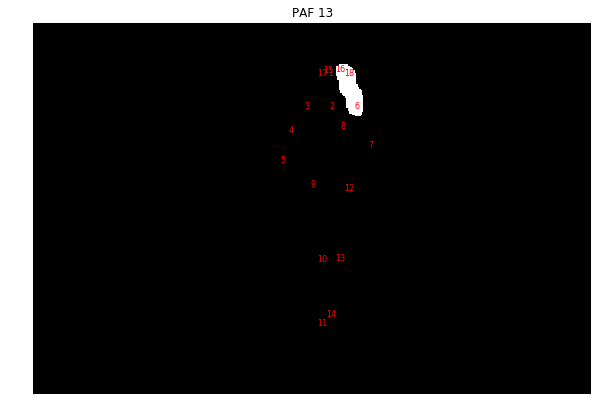

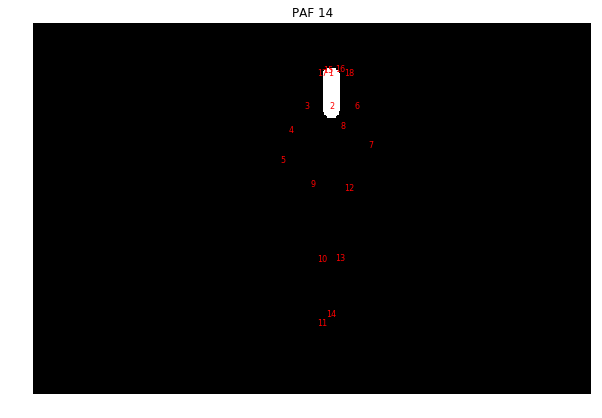

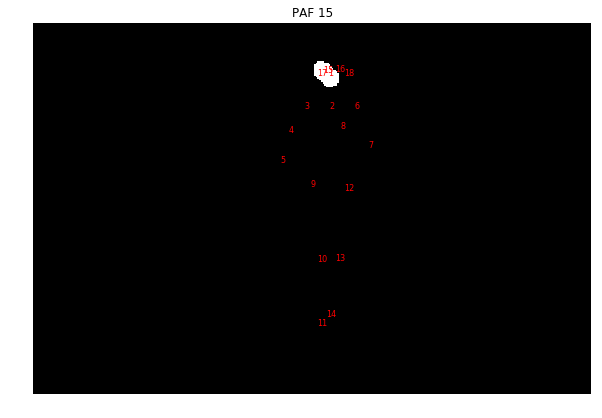

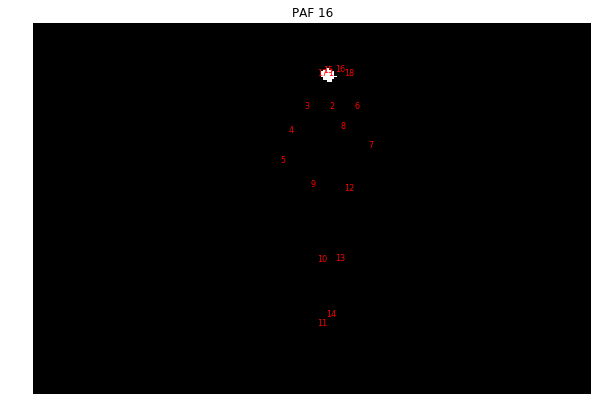

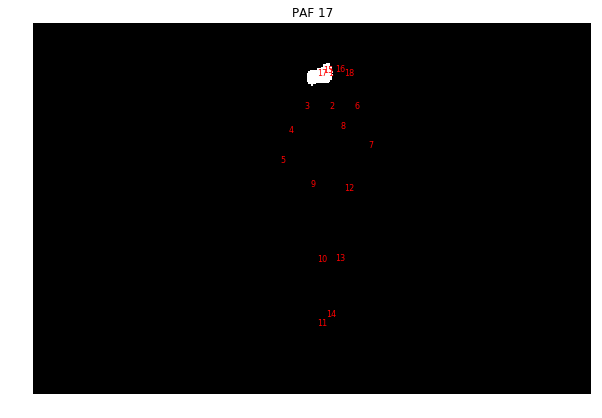

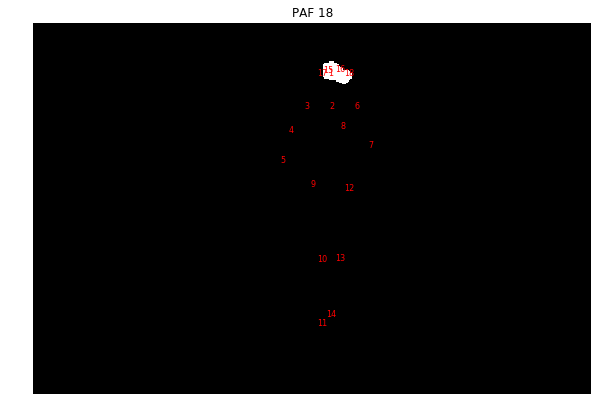

In [124]:
for i in range(len(paf_comb_thresh)):
    plt.figure(figsize=(10,10))
    # plt.subplot(4, 5, i + 1)
    plt.imshow(paf_comb_thresh[i], cmap=plt.cm.gray)
    plt.axis("off")
    plt.title("PAF " + str(i))
    
    for p in range(len(data['people'])):
        for i in range(len(data['people'][p]['pose_keypoints']['x'])):
            x_key = data['people'][p]['pose_keypoints']['x'][i]
            y_key = data['people'][p]['pose_keypoints']['y'][i]
            
            plt.annotate(i + 1, xy=(x_key,y_key), fontsize=8, color='red')
    plt.show()

In [72]:
# sure_fg = np.zeros(img.shape)
# for i in range(len(paf_comb_thresh)):
#     sure_fg = np.maximum(sure_fg, paf_comb_thresh[i])
    
# plt.imshow(sure_fg, cmap=plt.cm.gray)

### Region Segmentation

Image thresholding: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
<br>
Region growing: https://github.com/Panchamy/RegionGrowing
<br>
Watershed segementation: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
<br>
Blob detection (useful in future?): https://www.learnopencv.com/blob-detection-using-opencv-python-c/

In [16]:
def region_growing(img, seed, region_threshold=0.5, iterations=-1):
    #Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    region_size = 0
    intensity_difference = 0
    neighbor_points_list = []
    neighbor_intensity_list = []

    #Mean of the segmented region
    init_region_mean = float(img[seed])
    region_mean = float(img[seed])
    region = []

    #Input image parameters
    height, width = img.shape
    image_size = height * width

    #Initialize segmented output image
    segmented_img = np.zeros((height, width), np.uint8)

    it = 0

    # Region growing until intensity difference becomes greater than certain threshold
    # or the loop has run a certain number of iterations
    while True:
        segmented_img[seed[0], seed[1]] = 255
        region.append(img[seed[0], seed[1]])
        region_mean = (region_mean*region_size + img[seed[0], seed[1]])/(region_size+1)

        # print(img[seed[0], seed[1]], region_mean, region_size)
        region_size += 1

        #Loop through neighbor pixels
        for i in range(4):
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]

            #Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            #Add neighbor if inside and not already in segmented_img
            if check_inside:
                if segmented_img[x_new, y_new] == 0:
                    neighbor_points_list.append([x_new, y_new])
                    neighbor_intensity_list.append(img[x_new, y_new])
                    region.append(img[x_new, y_new])
                    segmented_img[x_new, y_new] = 255

                    region_mean = (region_mean*region_size + img[x_new, y_new])/(region_size+1)
                    # print(img[x_new, y_new], region_mean, region_size)
                    region_size += 1

        #Add pixel with intensity nearest to the mean to the region
        distance = abs(neighbor_intensity_list-region_mean)
        pixel_distance = min(distance)
        index = np.where(distance == pixel_distance)[0][0]

        #Update the seed value
        seed = neighbor_points_list[index]
        # print(seed)
        #Remove the value from the neighborhood lists
        neighbor_intensity_list[index] = neighbor_intensity_list[-1]
        neighbor_points_list[index] = neighbor_points_list[-1]

        it += 1
        # print(it)

        if iterations > -1:
            if it >= iterations:
                break
        else:
            if ((abs(region_mean - init_region_mean) > region_threshold) or 
                (region_size >= image_size)):
                break

    return segmented_img

In [18]:
body_region_seeds = []
for p in range(len(data_partition['people'])):
    body_region_seeds.append([])
    for i in range(len(PARTITION_BODY_PARTS)):
        seed_x = data_partition['people'][p]['pose_keypoints']['x'][i]
        seed_y = data_partition['people'][p]['pose_keypoints']['y'][i]
        body_region_seeds[p].append((seed_y, seed_x))

In [19]:
print(len(body_region_seeds[0]))

17


In [20]:
body_regions = []
for p in range(len(data_partition['people'])):
    body_regions.append([])
    for i in range(len(PARTITION_BODY_PARTS)):
        seed = body_region_seeds[p][i]
        body_regions[p].append(region_growing(cv2.blur(gray, (3,3)), seed, region_threshold=5))

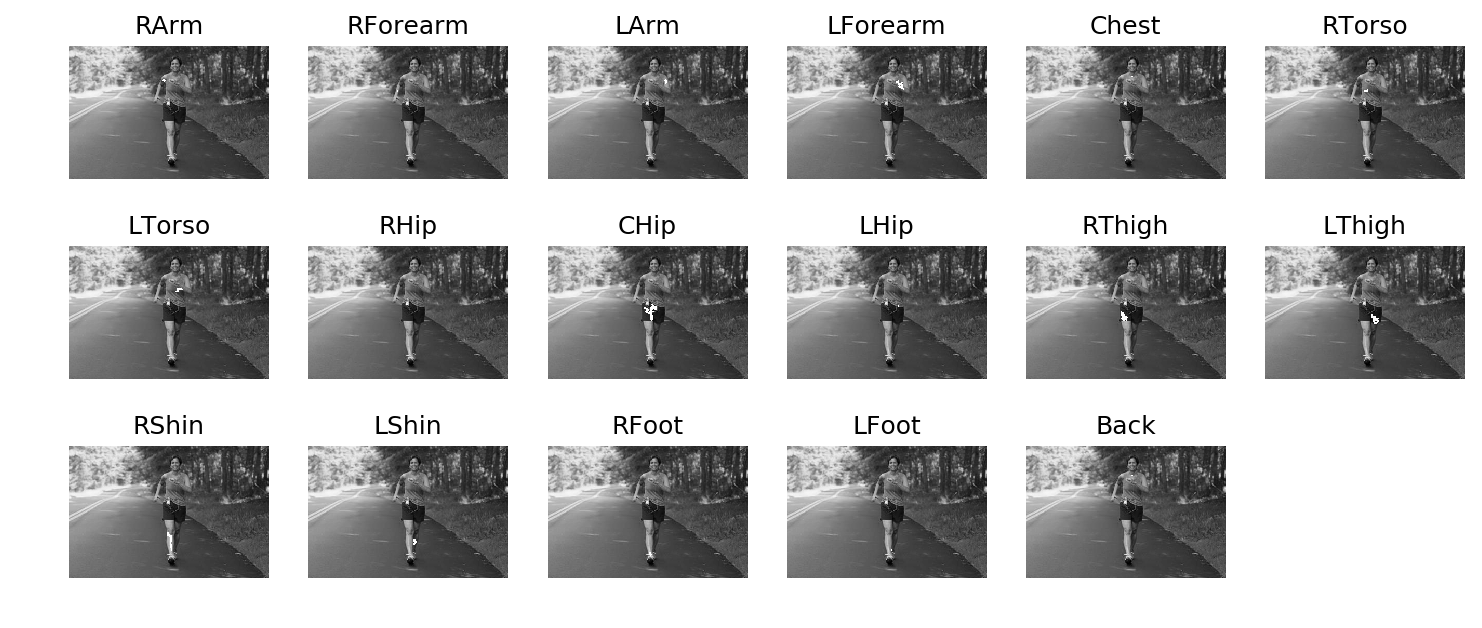

In [21]:
plt.figure(figsize=(12,5), dpi=150)
for r in range(len(body_regions[0])):
    plt.subplot(3, 6, r + 1)
    plt.imshow(np.maximum(body_regions[0][r], gray), cmap=plt.cm.gray)
    plt.title(PARTITION_BODY_PARTS.keys()[r])
    plt.axis('off')
plt.show()

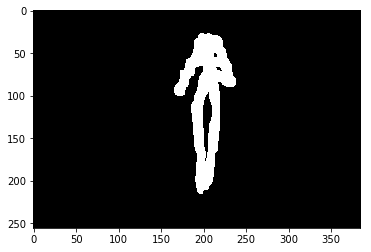

In [125]:
sure_fg = np.zeros(img.shape)
for i in range(len(paf_comb_thresh)):
    sure_fg = np.maximum(sure_fg, paf_comb_thresh[i])
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, cmap=plt.cm.gray)

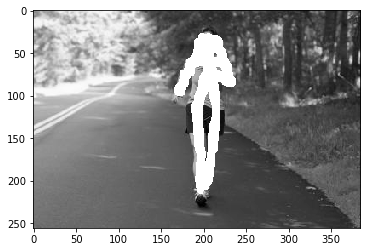

In [126]:
plt.imshow(np.maximum(sure_fg, img), cmap=plt.cm.gray)

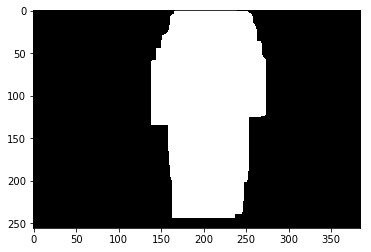

In [74]:
# noise removal
kernel = np.ones((10,10),np.uint8)
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
sure_bg = np.uint8(cv2.dilate(sure_fg, kernel, iterations = 7))
plt.imshow(sure_bg, cmap=plt.cm.gray)

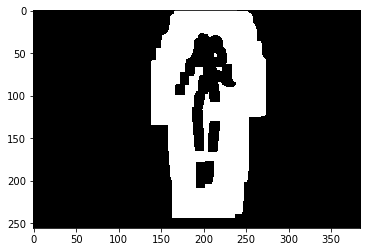

In [75]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap=plt.cm.gray)

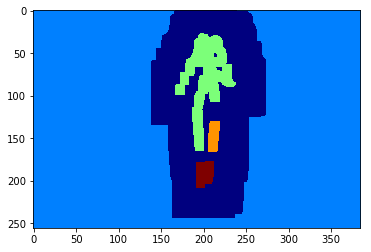

In [76]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# Dark blue = unknown regions
# Colored = sure regions
plt.imshow(markers, cmap=plt.cm.jet)

In [81]:
color = misc.imread(img_file)

In [82]:
markers = cv2.watershed(color,markers)
color[markers == -1] = [255,0,0]

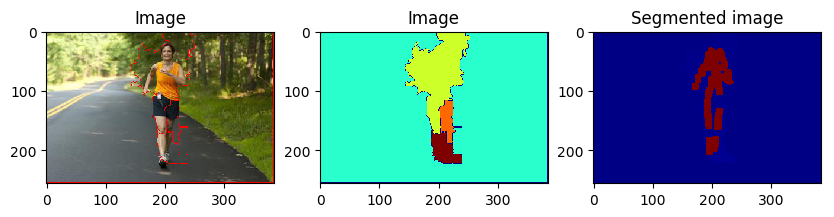

In [121]:
plt.figure(figsize=(10,6), dpi=100)

plt.subplot(131)
plt.imshow(color, cmap=plt.cm.gray)
# plt.axis('off')
plt.title('Image')

plt.subplot(132)
plt.imshow(markers, cmap=plt.cm.jet)
# plt.axis('off')
plt.title('Image')

plt.subplot(133)
plt.imshow(np.maximum(markers, sure_fg), cmap=plt.cm.jet)
# plt.axis('off')
plt.title('Segmented image')

plt.show()

In [28]:
cv2.imwrite('woman_markers.png', markers)

True

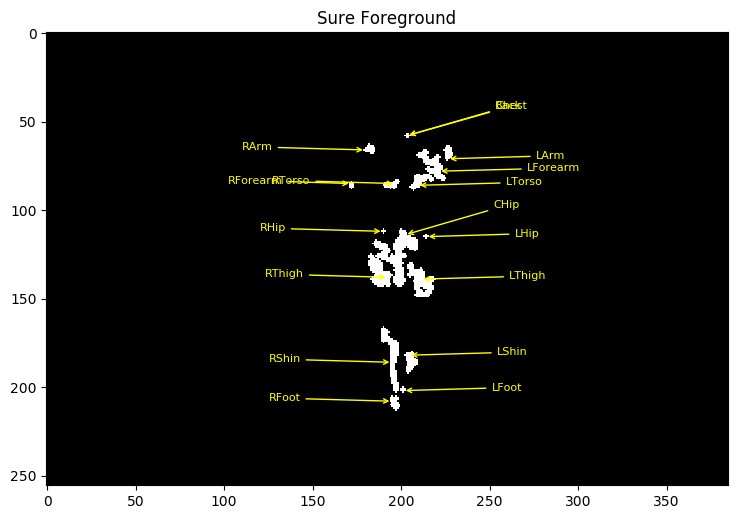

In [35]:
plt.figure(figsize=(10,6), dpi=100)

# plt.subplot(121)
plt.imshow(sure_fg, cmap=plt.cm.gray)
# plt.axis('off')
plt.title('Sure Foreground')

for p in range(len(data_partition['people'])):
    for i in range(len(data_partition['people'][p]['pose_keypoints']['x'])):
        x_key = data_partition['people'][p]['pose_keypoints']['x'][i]
        y_key = data_partition['people'][p]['pose_keypoints']['y'][i]
        if PARTITION_BODY_PARTS.keys()[i][0] == 'R':
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key - 70, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})
        elif PARTITION_BODY_PARTS.keys()[i][0] =='L':
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})
        else:
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key - 15), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'yellow'})
            
plt.show()

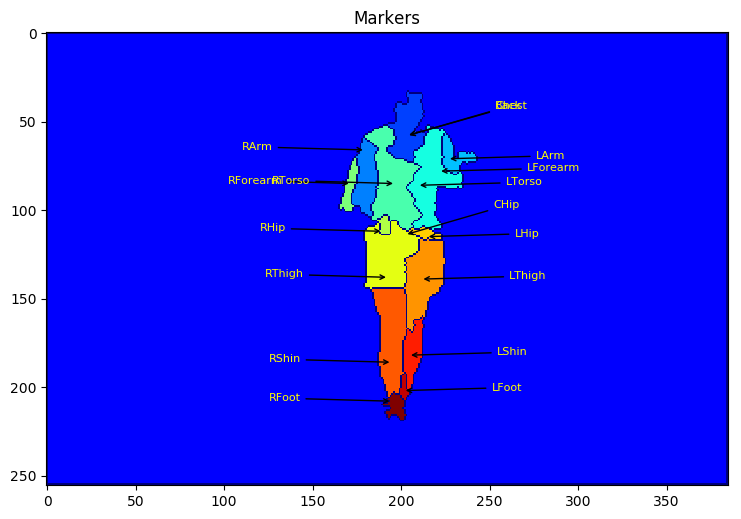

In [37]:
plt.figure(figsize=(10,6), dpi=100)

# plt.subplot(121)
plt.imshow(markers, cmap=plt.cm.jet)
# plt.axis('off')
plt.title('Markers')

for p in range(len(data_partition['people'])):
    for i in range(len(data_partition['people'][p]['pose_keypoints']['x'])):
        x_key = data_partition['people'][p]['pose_keypoints']['x'][i]
        y_key = data_partition['people'][p]['pose_keypoints']['y'][i]
        if PARTITION_BODY_PARTS.keys()[i][0] == 'R':
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key - 70, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'black'})
        elif PARTITION_BODY_PARTS.keys()[i][0] =='L':
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'black'})
        else:
            plt.annotate(PARTITION_BODY_PARTS.keys()[i], xy=(x_key,y_key), xytext=(x_key + 50, y_key - 15), 
                         fontsize=8, color='yellow',
                         arrowprops={'arrowstyle':'->', 'color':'black'})

plt.show()